In [1]:
!pip install git+https://github.com/ComputationalCryoEM/ASPIRE-Python.git
!git clone https://github.com/ComputationalCryoEM/ASPIRE-Python.git
%cd ASPIRE-Python

  Cloning https://github.com/ComputationalCryoEM/ASPIRE-Python.git to /tmp/pip-req-build-tel39djj
  Running command git clone --filter=blob:none --quiet https://github.com/ComputationalCryoEM/ASPIRE-Python.git /tmp/pip-req-build-tel39djj
  Resolved https://github.com/ComputationalCryoEM/ASPIRE-Python.git to commit f8f26eed4a30a1c8b0383ab4ff543e40b6a5491f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 23.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 57.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 107.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
  Created wheel for aspire: filename=aspire-0.14.0-py3-none-any.whl size=426485 sha256=1cc24e6

# 1.Downloading a high resolution volume map of the 80S

In [2]:

from aspire.downloader import emdb_2660
original_vol = emdb_2660()
res = 64
vol_ds = original_vol.downsample(res) #downsampling to compare the result with original

2025-10-02 18:23:48,449 INFO [numexpr.utils] NumExpr defaulting to 4 threads.


DEBUG:2025-10-02 18:23:51,175:jax._src.path:31: etils.epath found. Using etils.epath for file I/O.
2025-10-02 18:23:57.342140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759429437.518883      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759429437.576158      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2025-10-02 18:24:20,666 INFO [aspire.volume.volume] /root/.cache/ASPIRE-data/emdb_2660.map with dtype float32 loaded as None


# 2.**``Simulation`` class for generating a synthetic dataset of projection images. And Creating ``CTF`` filter for correcting the image distortions caused by the microscope's** 

In [3]:
# Create CTF filters
import numpy as np

from aspire.operators import RadialCTFFilter

# Radial CTF Filter
defocus_min = 15000  # unit is angstroms
defocus_max = 25000
defocus_ct = 7

ctf_filters = [
    RadialCTFFilter(pixel_size=original_vol.pixel_size, defocus=d)
    for d in np.linspace(defocus_min, defocus_max, defocus_ct)
]

#Simulating projections

from aspire.noise import WhiteNoiseAdder
from aspire.source import Simulation
src = Simulation(
    n=2500,  # number of projections
    vols=original_vol,  # volume source
    offsets=0,  # Default: images are randomly shifted
    unique_filters=ctf_filters,
    noise_adder=WhiteNoiseAdder(var=0.0002),  # desired noise variance
).cache()  #prevent regenerating the projections


2025-10-02 18:49:55,594 INFO [aspire.source.image] Creating Simulation with 2500 images.
2025-10-02 18:49:55,667 INFO [aspire.source.simulation] Appending WhiteNoiseAdder with variance=0.0002 to generation pipeline
2025-10-02 18:49:55,738 INFO [aspire.source.image] Caching source images


100%|██████████| 5/5 [04:17<00:00, 51.54s/it]


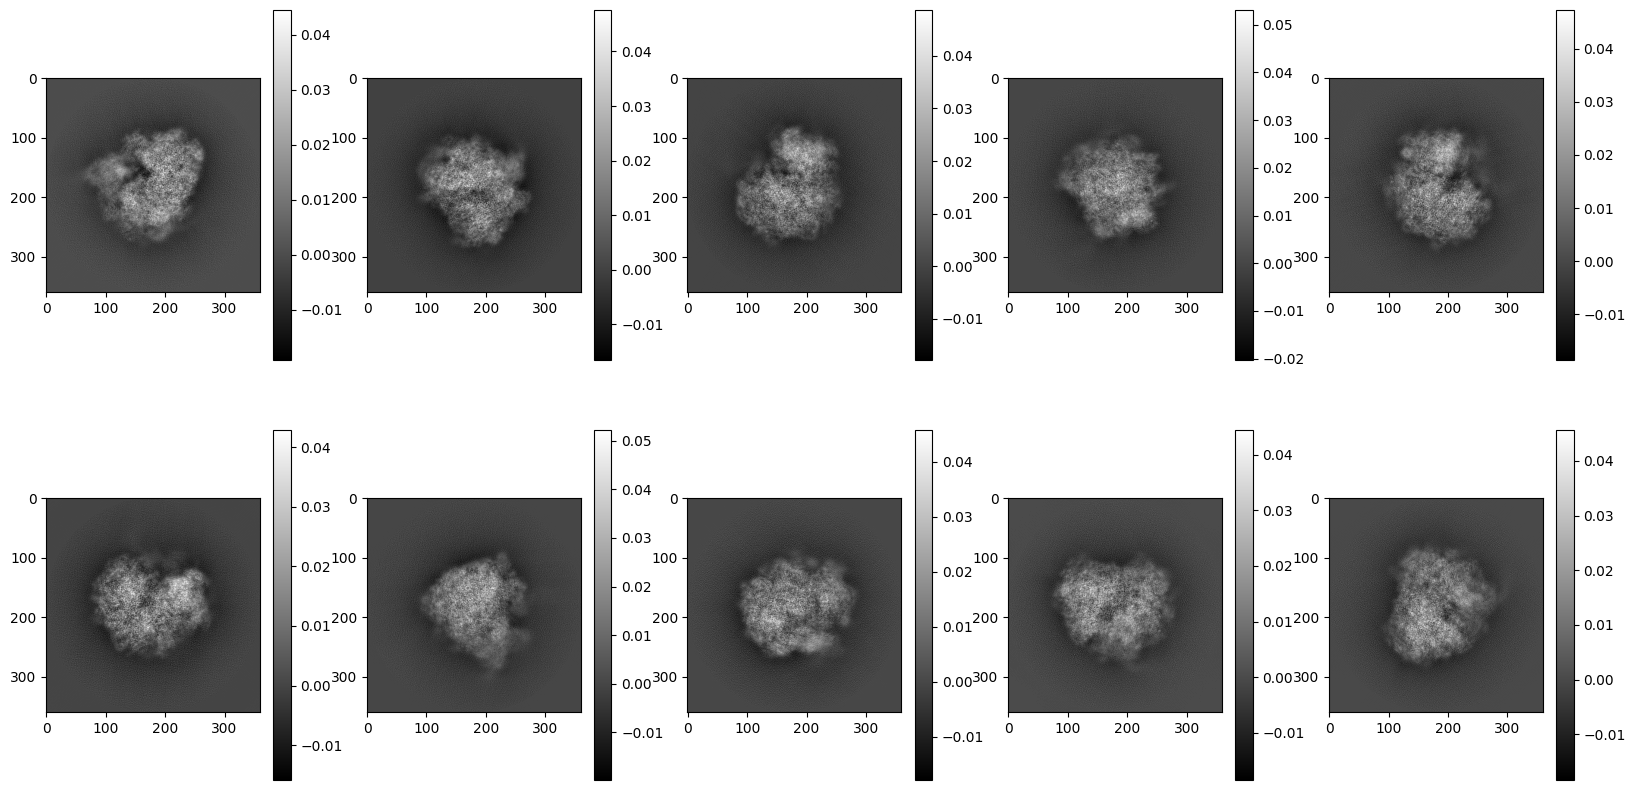

In [5]:
#noiseless, no-CTF projections of the volume (Radon projections)
src.projections[0:10].show()

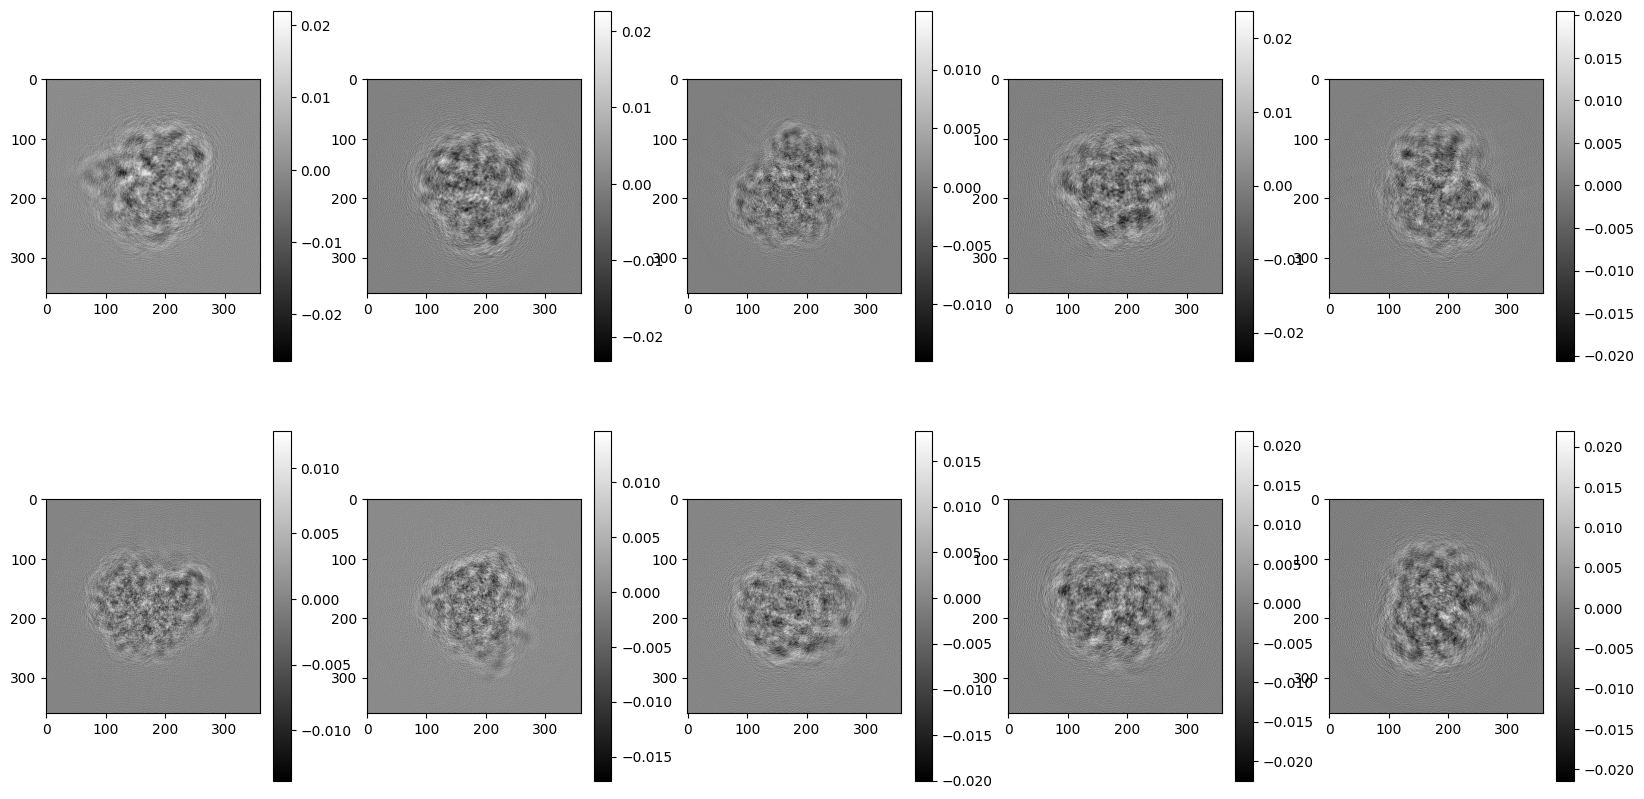

In [6]:
# projections with CTF corruption applied, but without additive noise.
src.clean_images[0:10].show()

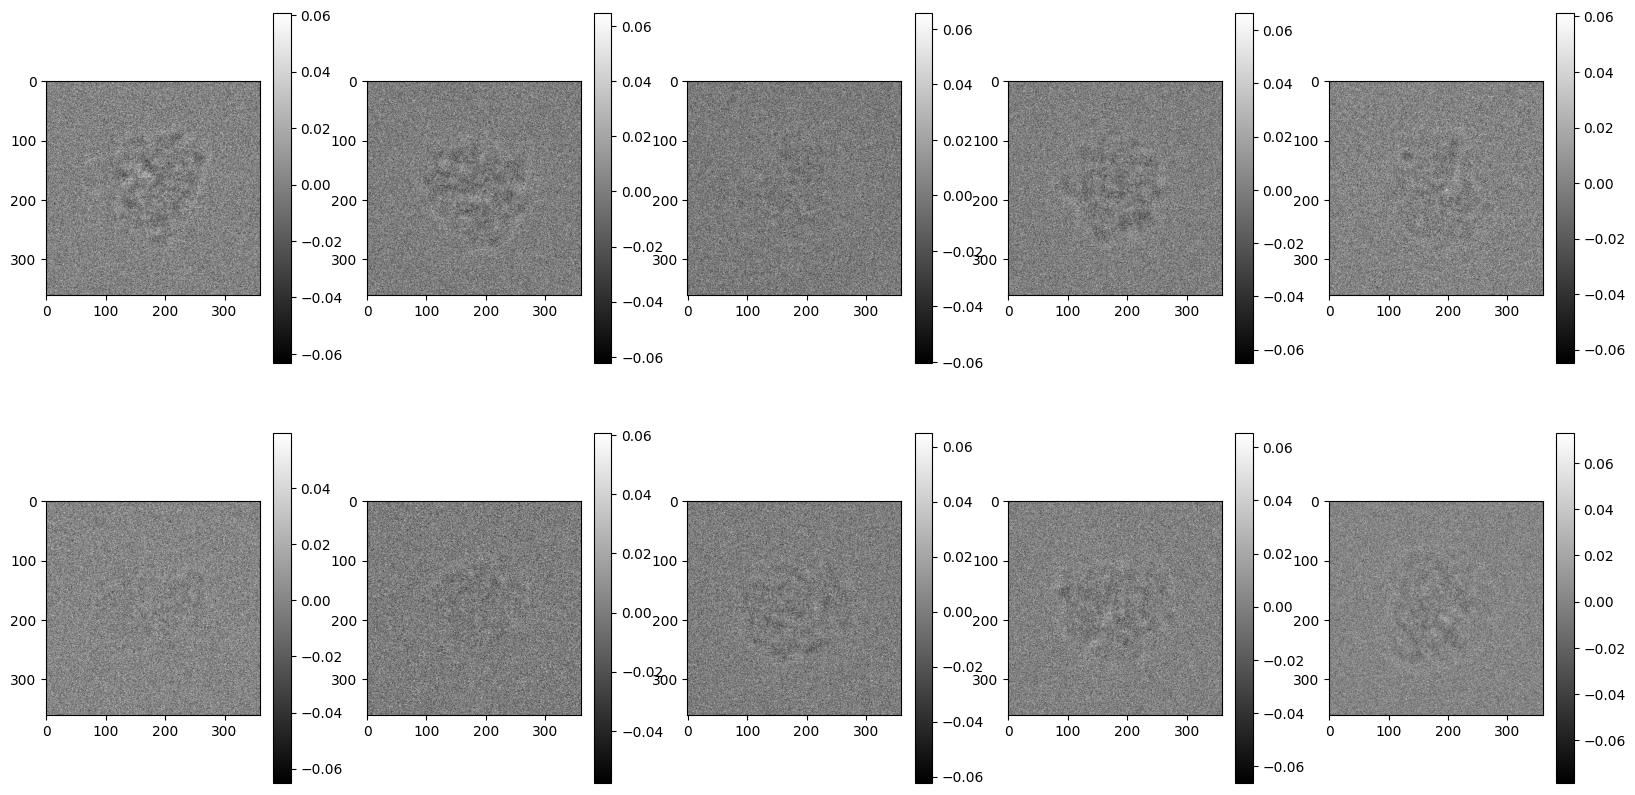

In [7]:
#projections with both CTF + noise.
src.images[0:10].show()

2025-10-02 19:16:26,989 INFO [aspire.source.image] Setting max. resolution of source = 64


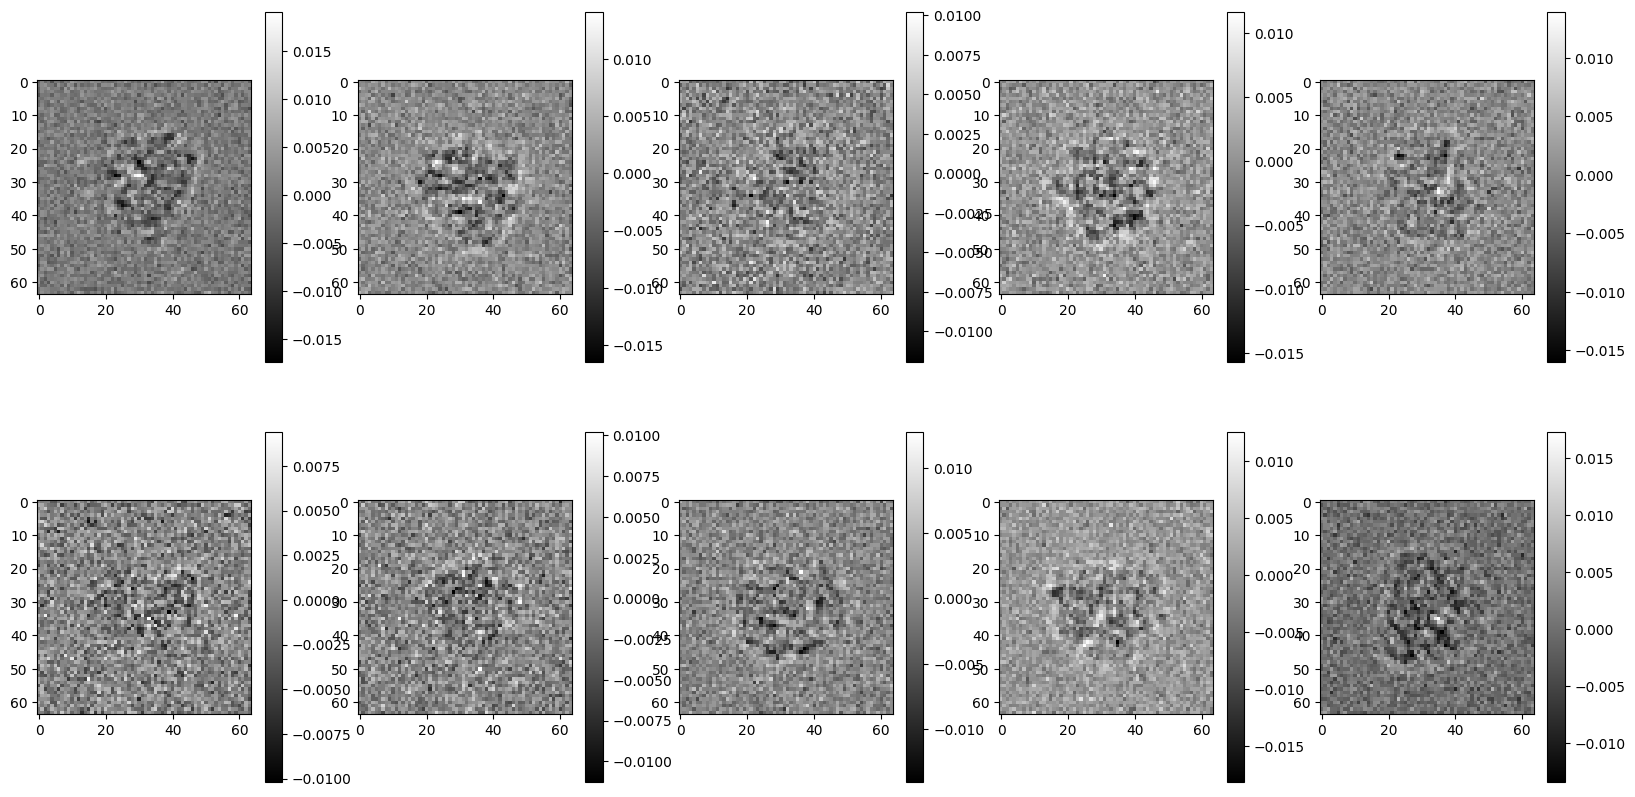

In [9]:
#Reduce image size for faster computation
src = src.downsample(res)
src.images[:10].show()

2025-10-02 19:17:48,130 INFO [aspire.source.image] Perform phase flip on source object
2025-10-02 19:17:48,131 INFO [aspire.source.image] Adding Phase Flip Xform to end of generation pipeline


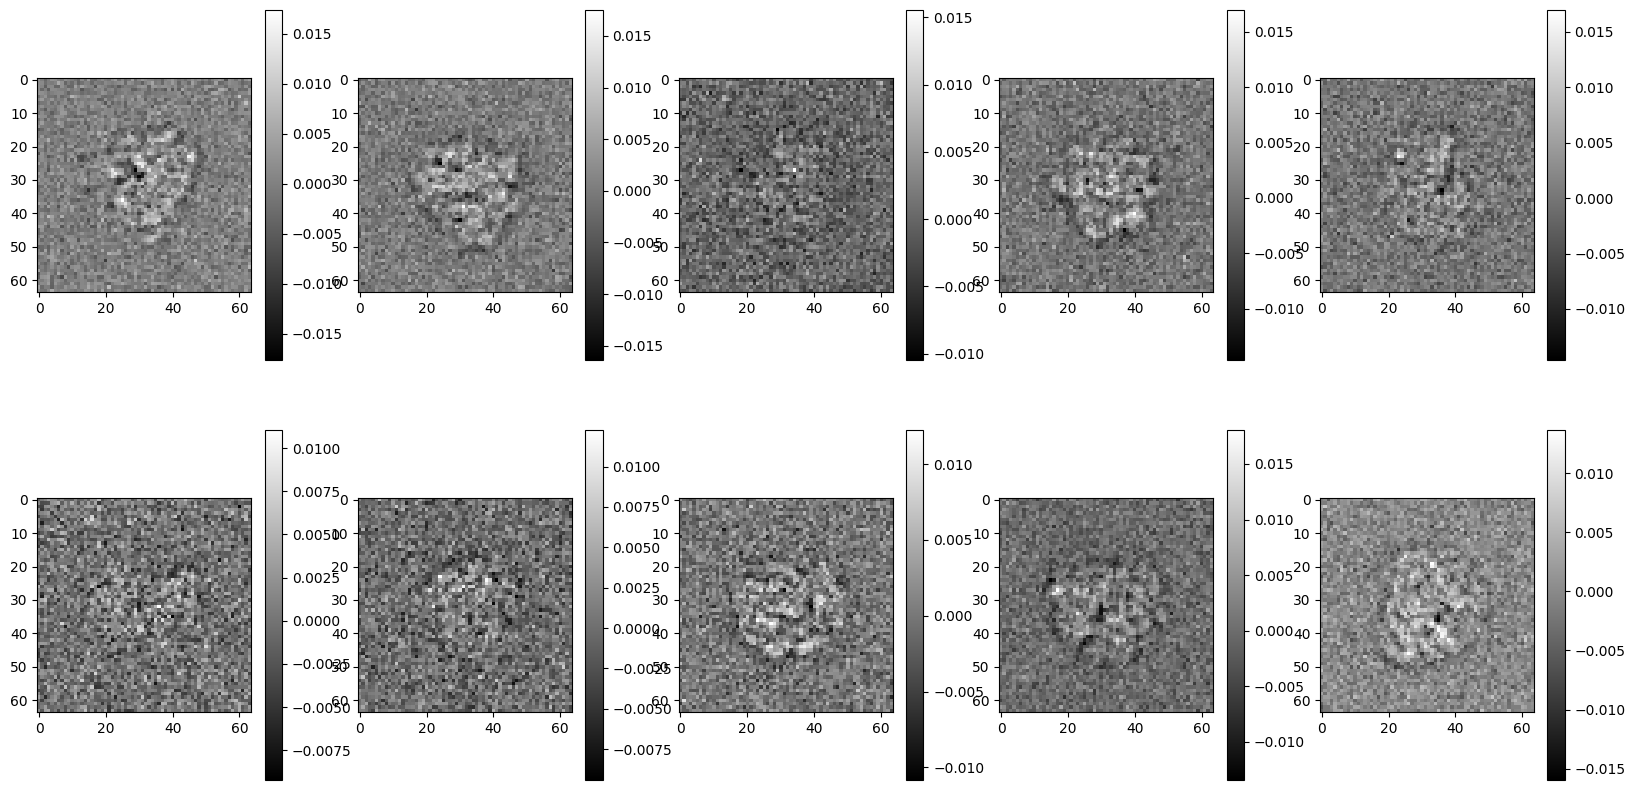

In [10]:
# Apply ``phase_flip()`` to correct for CTF effects.

src = src.phase_flip()
src.images[:10].show()

2025-10-02 19:22:34,002 INFO [aspire.source.image] Normalize background on source object with radius size of 1.0 and do_ramp of True


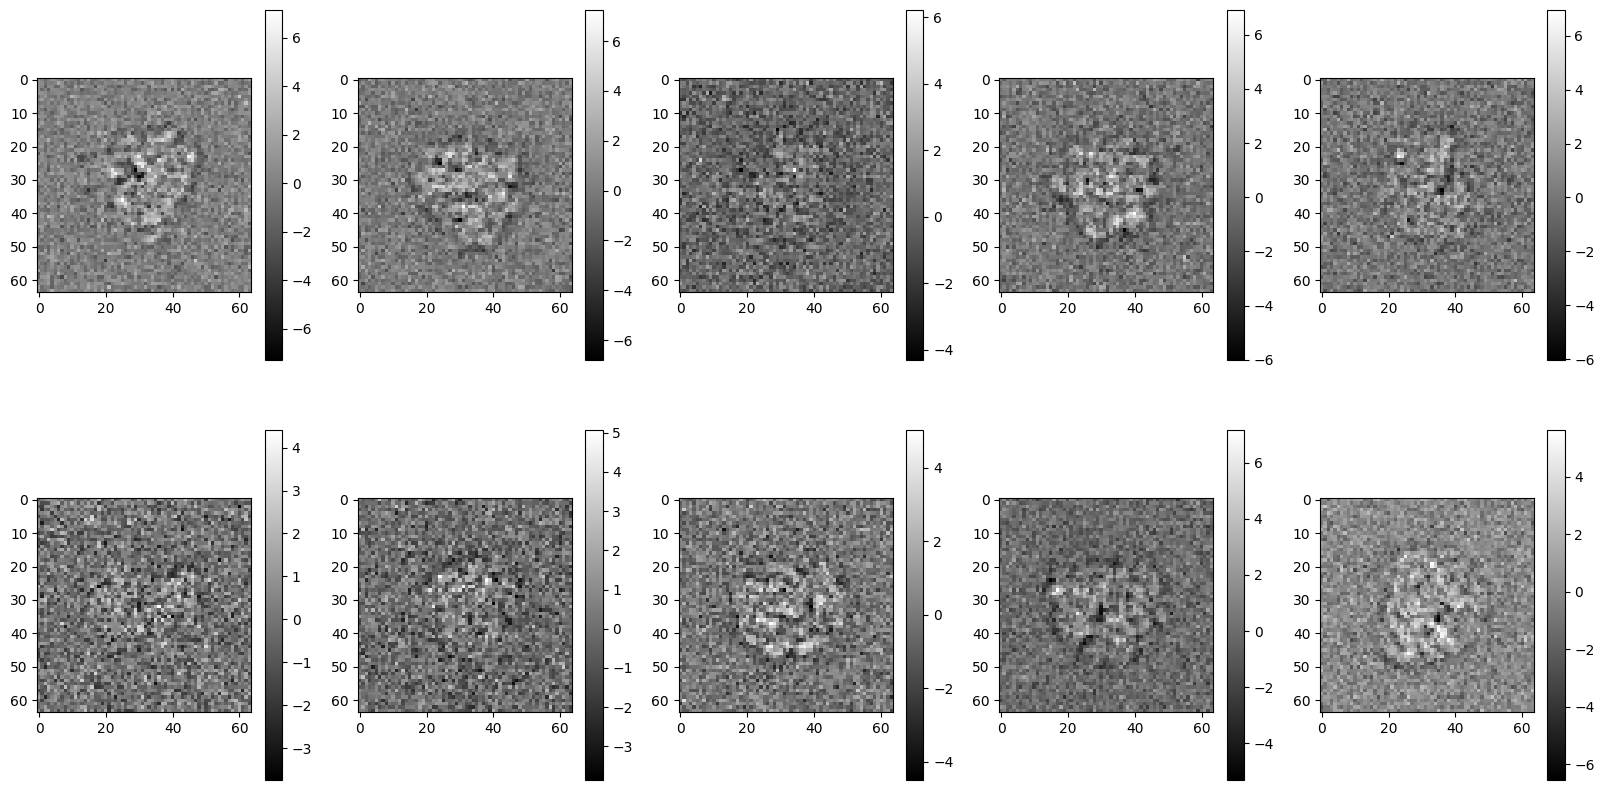

In [11]:
# Applying ``normalize_background()`` to adjust the background before class averaging
src = src.normalize_background()
src.images[:10].show()

2025-10-02 19:25:47,624 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

2025-10-02 19:25:52,449 INFO [aspire.noise.noise] Noise variance = 1.0000958449824928
2025-10-02 19:25:52,454 INFO [aspire.source.image] Whitening source object
2025-10-02 19:25:52,457 INFO [aspire.source.image] Transforming all CTF Filters into Multiplicative Filters
2025-10-02 19:25:52,457 INFO [aspire.source.image] Adding Whitening Filter Xform to end of generation pipeline


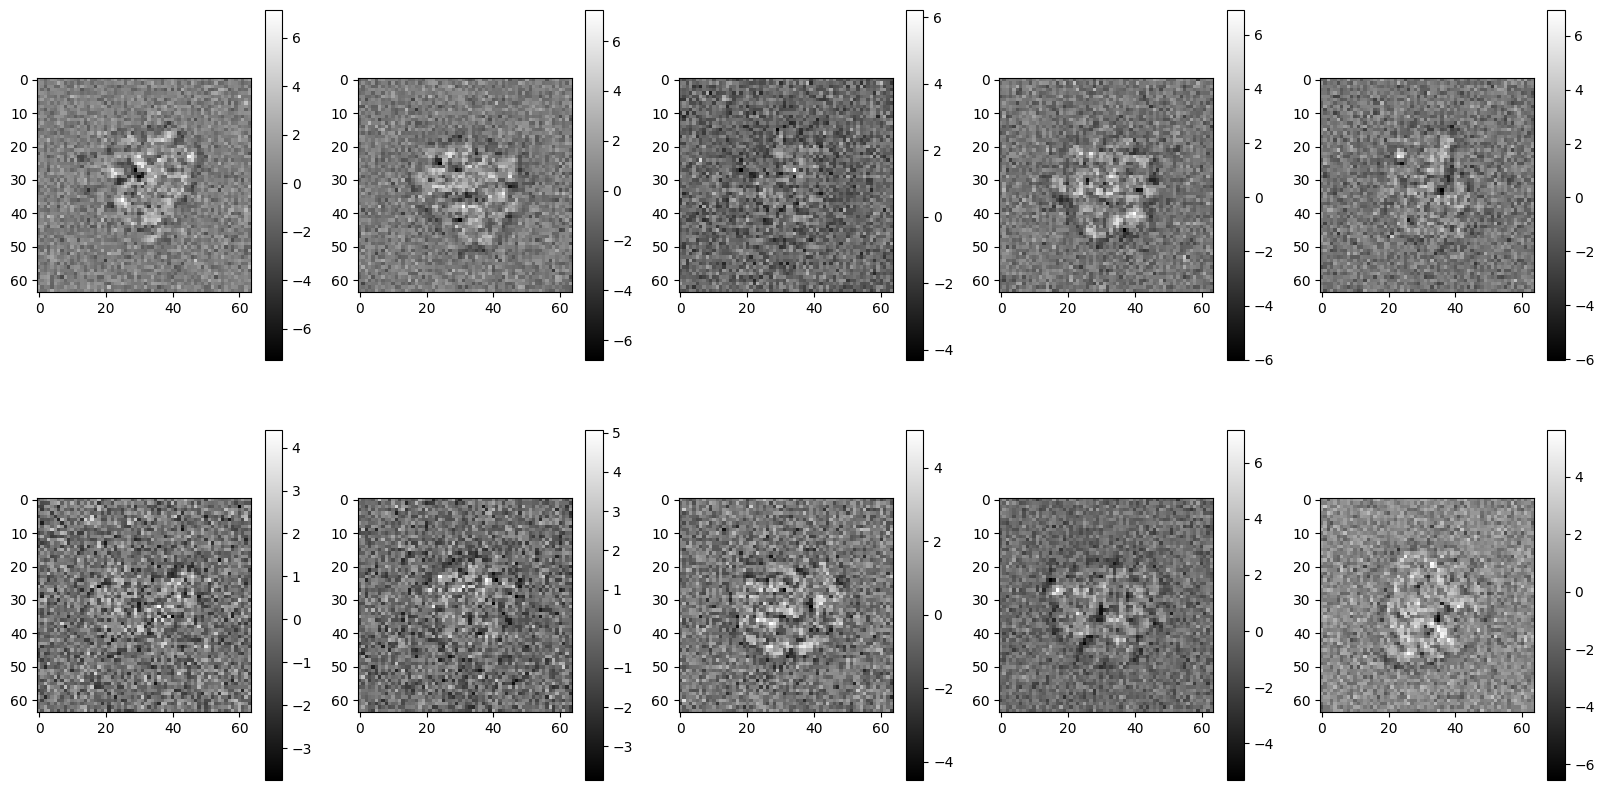

In [12]:
# Applying ``whiten()`` to estimate and whiten the noise (equilizing noise variance)

src = src.whiten()
src.images[:10].show()

2025-10-02 19:29:31,238 INFO [aspire.source.image] Apply contrast inversion on source object
2025-10-02 19:29:31,239 INFO [aspire.source.image] Computing signal vs background contrast on source object


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

2025-10-02 19:29:36,312 INFO [aspire.source.image] No need to invert contrast
2025-10-02 19:29:36,312 INFO [aspire.source.image] Adding Scaling Xform to end of generation pipeline


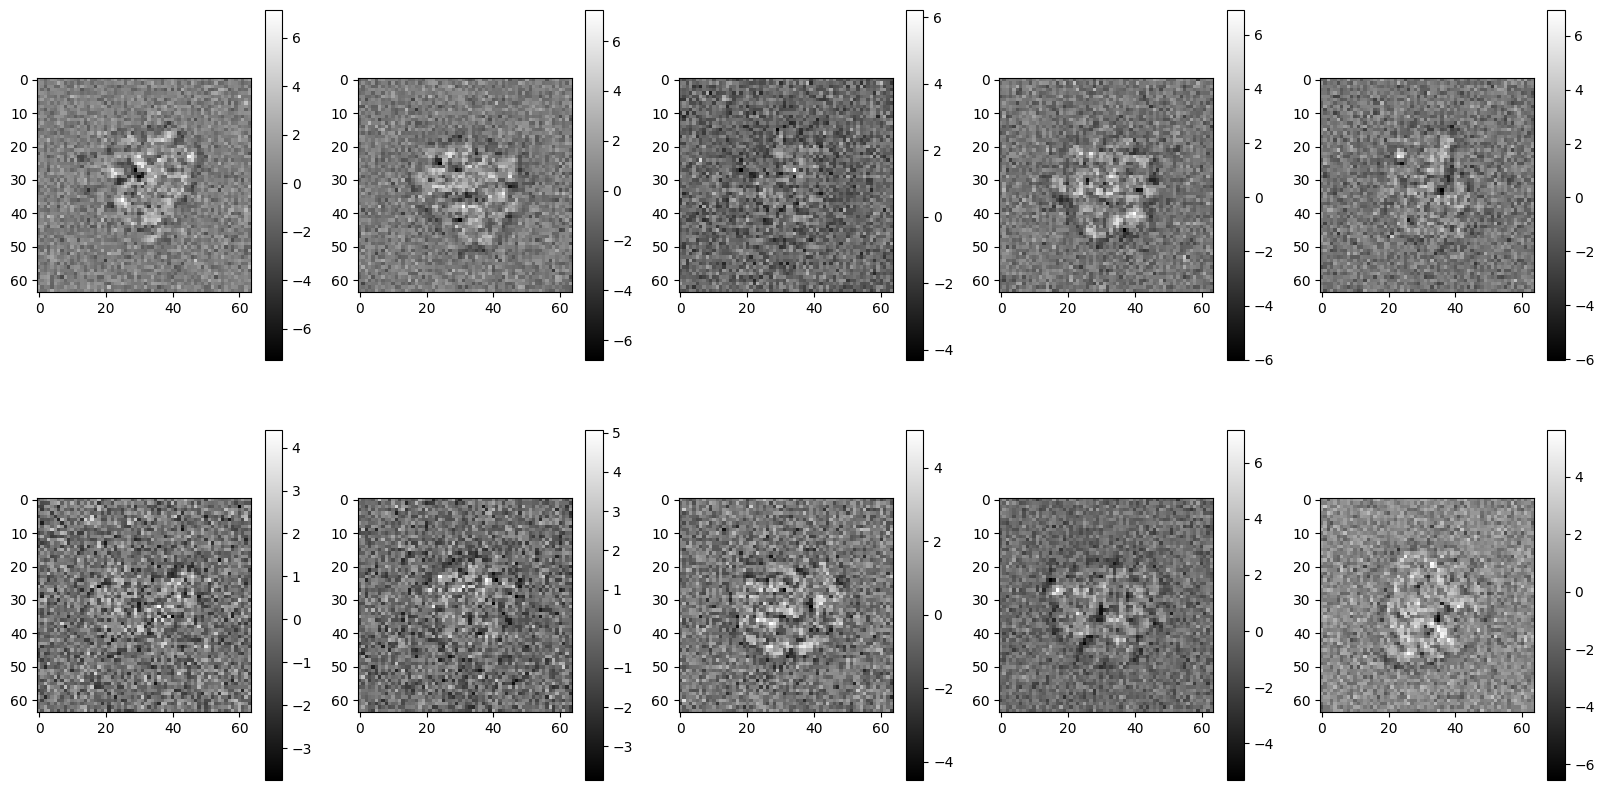

In [13]:
#to ensure a positive valued signal.
src = src.invert_contrast()
src.images[:10].show()

In [14]:
# for re-applying all those steps (downsampling → phase flip → normalize → whiten → invert)
src = src.cache()

2025-10-02 19:32:53,581 INFO [aspire.source.image] Caching source images


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


# **3.Class Averaging (preprocessing)**

2025-10-02 20:10:23,322 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2025-10-02 20:10:23,762 INFO [aspire.source.image] Creating DebugClassAvgSource with 2500 images.
2025-10-02 20:10:23,763 INFO [aspire.source.image] Creating IndexedSource with 250 images.
2025-10-02 20:10:23,848 INFO [aspire.source.image] Caching source images


  0%|          | 0/1 [00:00<?, ?it/s]

2025-10-02 20:10:23,851 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2025-10-02 20:10:24,228 INFO [aspire.basis.fspca] Estimating the noise of images.
2025-10-02 20:10:24,229 INFO [aspire.noise.noise] Determining Noise variance in batches of 512



100%|██████████| 5/5 [00:00<00:00, 114.76it/s]

2025-10-02 20:10:24,276 INFO [aspire.noise.noise] Noise variance = 0.9999998292702785
2025-10-02 20:10:24,277 INFO [aspire.basis.fspca] Setting noise_var=0.9999998211860657
2025-10-02 20:10:24,278 INFO [aspire.covariance.covar2d] Represent CTF filters in basis


2025-10-02 20:10:27,606 WARNING [aspire.covariance.covar2d] Left side b after removing noise in Batched Cov2D is not positive semidefinite.
2025-10-02 20:10:28,077 WARNING [aspire.covariance.covar2d] Covariance matrix in Batched Cov2D is not positive semidefinite.
2025-10-02 20:10:28,078 INFO [aspire.covariance.covar2d] Convert matrices to positive semidefinite.
2025-10-02 20:10:36,358 INFO [aspire.classification.rir_class2d] Calculate Nearest Neighbors using legacy.



100%|██████████| 5/5 [00:00<00:00,  6.93it/s]

Rotationally aligning classes: 100%|██████████| 250/250 [00:06<00:00, 41.61it/s]

Stacking and evaluating class averages from FFBBasis2D to Cartesian:   0%|          | 0/1 [00:00<?, ?it/s]

Stacking batch:   0%|          | 0/250 [00:00<?, ?it/s]

Stacking batch:   3%|▎         | 8/250 [00:00<00:03, 78.20it/s]

Stacking batch:   6%|▋         | 16/250 [00:00<00:03, 77.34it/s]

Stacking batch:  10%|▉         | 24/250 [00:00<00:02, 77.53it/s]

Stacking batch:  13%|█▎        | 32/250 [00:00<00:02, 77.66it/s]

Stacking batch:  16%|█▌        | 40/250 [00:00<00:02, 76.75it/s]

Stacking batch:  19%|█▉        | 48/250 [00:00<00:02, 77.06it/s]

Stacking batch:  22%|██▏       | 56/250 [00:00<00:02, 76.72it/s]

Stacking batch:  26%|██▌       | 64/250 [00:00<00:02, 76.82it/s]

Stacking batch:  29%|██▉       | 72/250 [00:00<00:02, 77.35it/s]

Stacking batch:  32%|███▏      | 80/250 [00:01<00:02, 77.47it/s]

Stacking batch:  35%|███▌      | 88/250 [00:01

Showing class averages


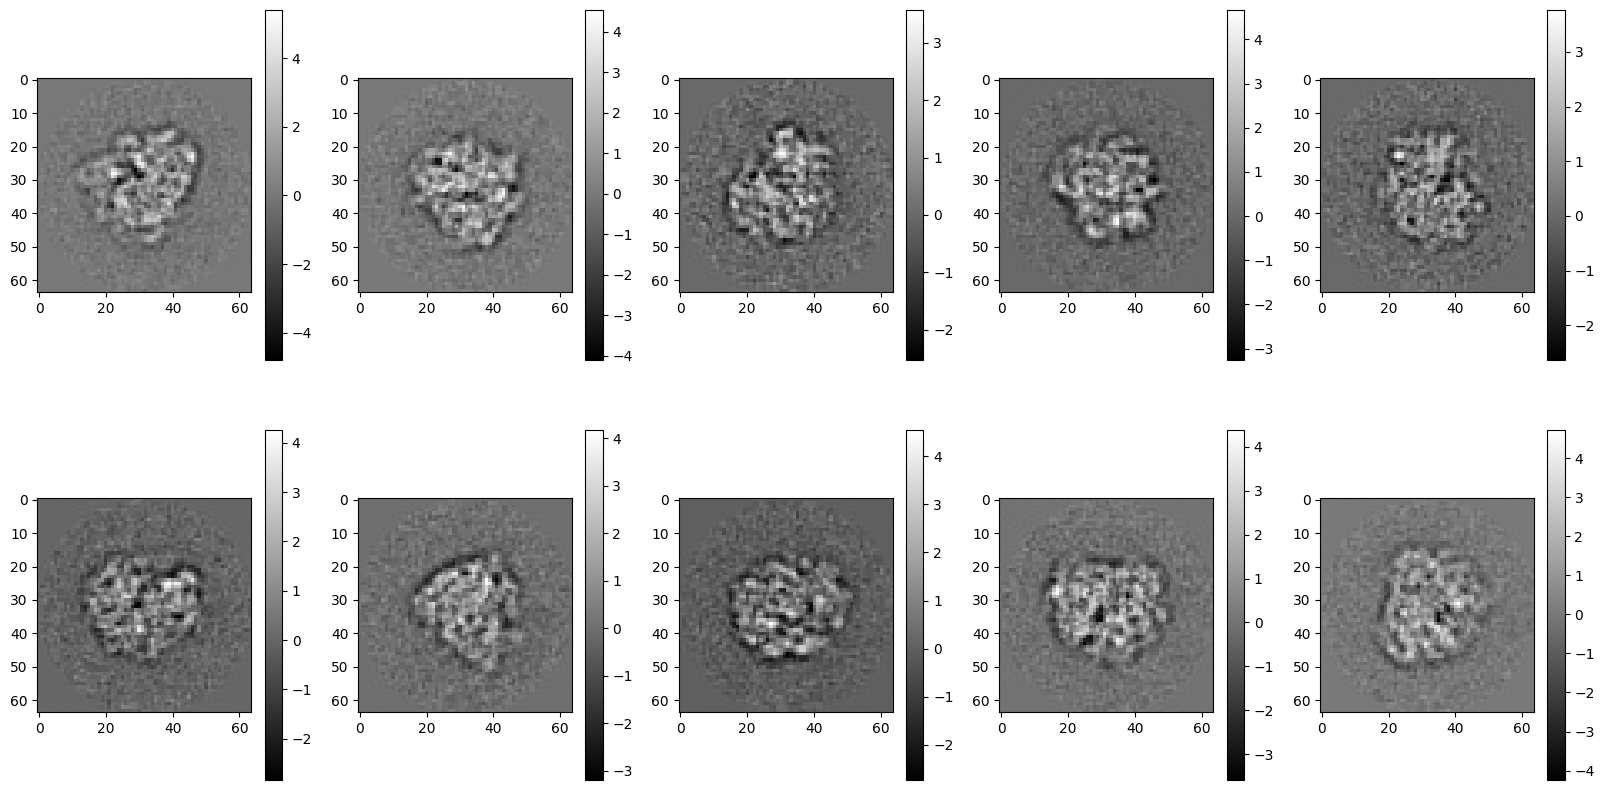

Showing original images corresponding to those classe


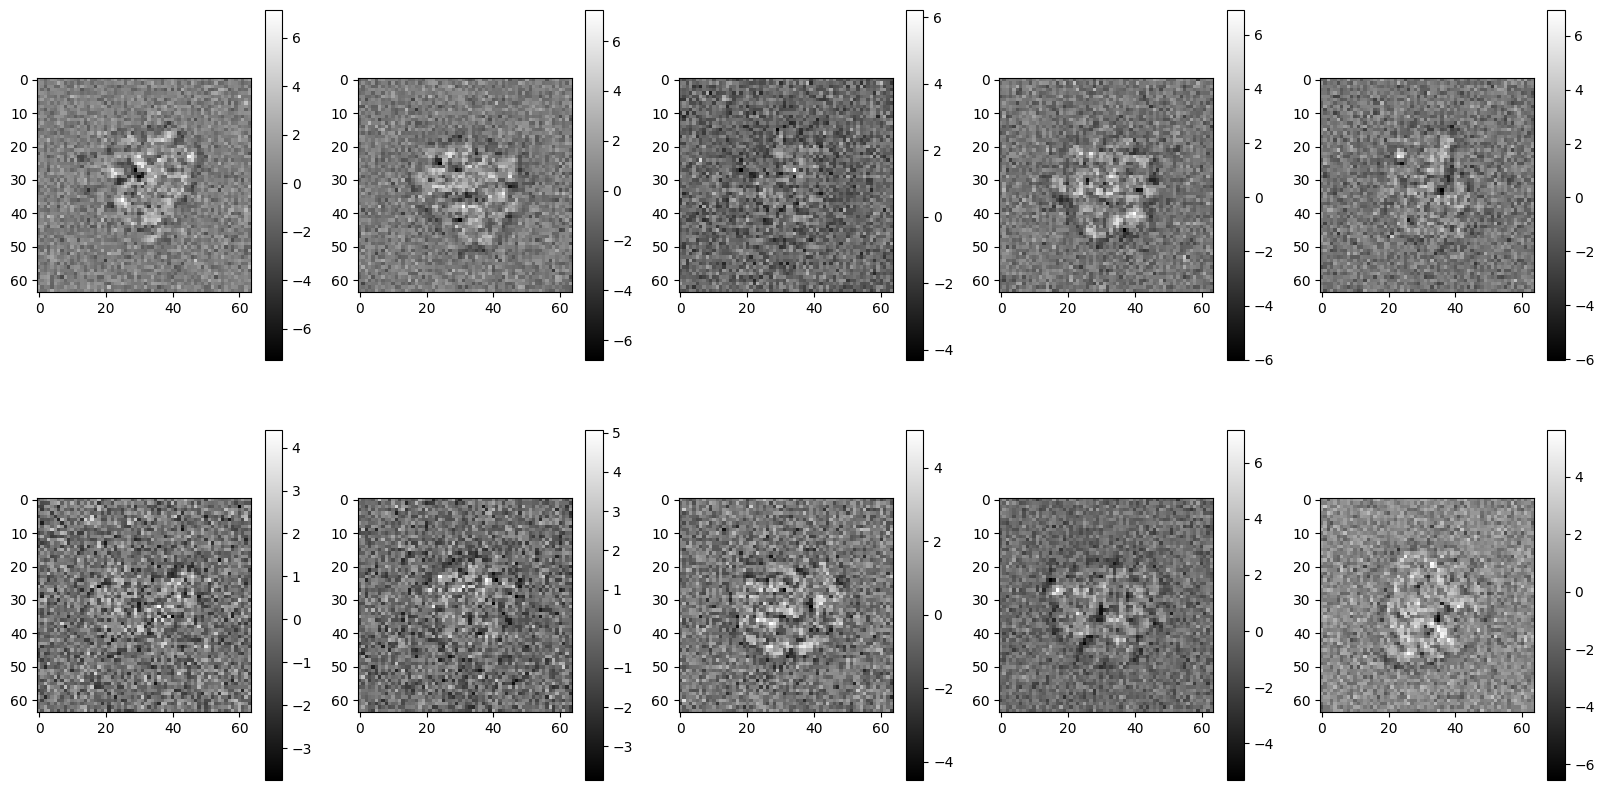

In [23]:
'''
Problem: Individual cryo-EM particles are extremely noisy. 
Solution: By aligning and averaging similar particles (Rotation Invariant), the noise averages out.
'''
from aspire.denoising import DebugClassAvgSource

avgs = DebugClassAvgSource(src=src)
n_classes = 250
avgs = avgs[:n_classes].cache()
print("Showing class averages")
avgs.images[0:10].show()

print("Showing original images corresponding to those classe")
# Show original images corresponding to those classes. This 1:1
# comparison is only expected to work because we used
# ``TopClassSelector`` to classify our images.
src.images[0:10].show()



# **4.Orientation Estimation (common line detection -> Rotation matrix estimation)** 

In [24]:

from aspire.abinitio import CLSyncVoting
#``CLSyncVoting`` algorithm employs a common-lines method with synchronization and voting, which estimates the rotation.
from aspire.source import OrientedSource
from aspire.utils import Rotation

# Stash true rotations for later comparison
true_rotations = Rotation(src.rotations[:n_classes])

# Instantiate a ``CLSyncVoting`` object for estimating orientations.
orient_est = CLSyncVoting(avgs)

# Instantiate an ``OrientedSource``.
oriented_src = OrientedSource(avgs, orient_est)

# Estimate Rotations.
est_rotations = oriented_src.rotations


2025-10-02 20:16:18,828 INFO [aspire.abinitio.commonline_base] cupy and GPU 0 found by cuda runtime; enabling cupy.
2025-10-02 20:16:18,831 INFO [aspire.source.image] Creating OrientedSource with 250 images.
2025-10-02 20:16:18,832 INFO [aspire.source.image] Estimating rotations and shifts for IndexedSource mapping 250 of 2500 indices from DebugClassAvgSource. using <aspire.abinitio.commonline_sync.CLSyncVoting object at 0x78c12c4c6050>.
2025-10-02 20:16:18,833 INFO [aspire.abinitio.commonline_base] Begin building Common Lines Matrix
2025-10-02 20:16:18,841 INFO [aspire.operators.polar_ft] Represent 2D image in a polar Fourier grid
2025-10-02 20:16:22,728 INFO [aspire.abinitio.commonline_base] Launching `build_clmatrix_kernel`.
2025-10-02 20:16:40,981 INFO [aspire.abinitio.commonline_base] Using existing estimated `clmatrix`.
2025-10-02 20:17:10,927 INFO [aspire.abinitio.commonline_sync] Top 10 eigenvalues from synchronization voting matrix: [171.05917   164.66371   160.68805    13.370

In [26]:
# %%
# Mean Error of Estimated Rotations

from aspire.utils import mean_aligned_angular_distance

# Compare with known true rotations
mean_ang_dist = mean_aligned_angular_distance(est_rotations, true_rotations)
print(f"Mean aligned angular distance: {mean_ang_dist} degrees")

Mean aligned angular distance: 1.9023442876319514 degrees


# **5.Volume Reconstruction**


2025-10-02 20:42:52,263 INFO [aspire.reconstruction.estimator] MeanEstimator instantiating default basis.
2025-10-02 20:42:52,265 INFO [aspire.basis.ffb_3d] Expanding 3D map in a frequency-domain Fourier–Bessel basis using the fast method.
2025-10-02 20:42:54,964 INFO [aspire.reconstruction.mean] Determined weighted adjoint mappings. Shape = (1, 69546)
2025-10-02 20:42:54,965 INFO [aspire.reconstruction.estimator] Computing kernel
2025-10-02 20:42:55,516 INFO [aspire.reconstruction.mean] Computing non-centered Fourier Transform Kernel Mat
2025-10-02 20:42:55,538 INFO [aspire.reconstruction.estimator] Computing Preconditioner kernel
2025-10-02 20:42:55,539 INFO [aspire.reconstruction.kernel] Circularizing kernel
2025-10-02 20:42:55,556 INFO [aspire.reconstruction.kernel] Circularizing dimension 0
2025-10-02 20:42:55,560 INFO [aspire.reconstruction.kernel] Circularizing dimension 1
2025-10-02 20:42:55,562 INFO [aspire.reconstruction.kernel] Circularizing dimension 2
2025-10-02 20:42:58,7

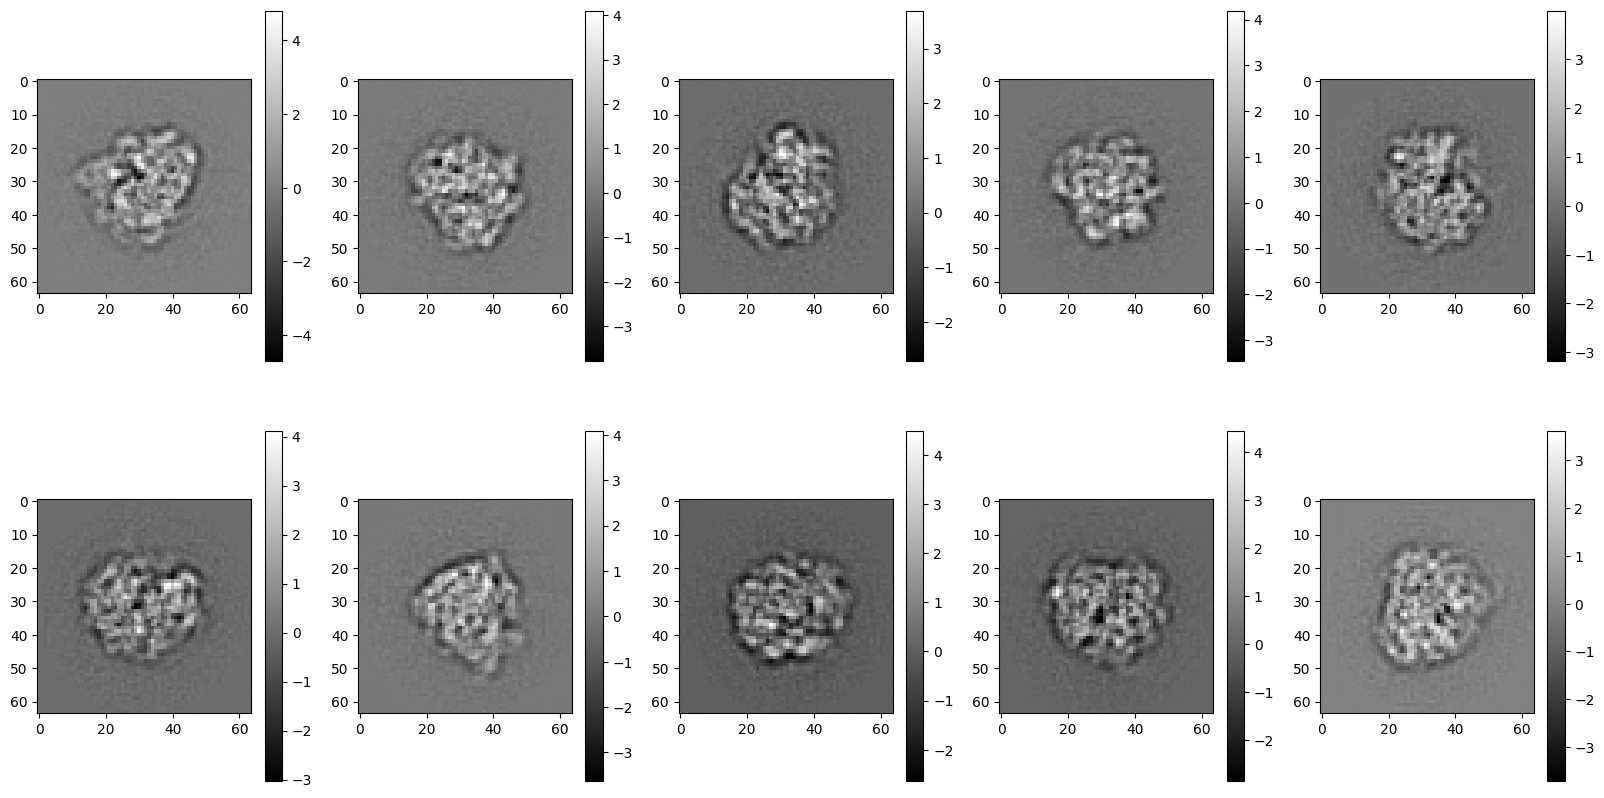

-----simulated source Projections______


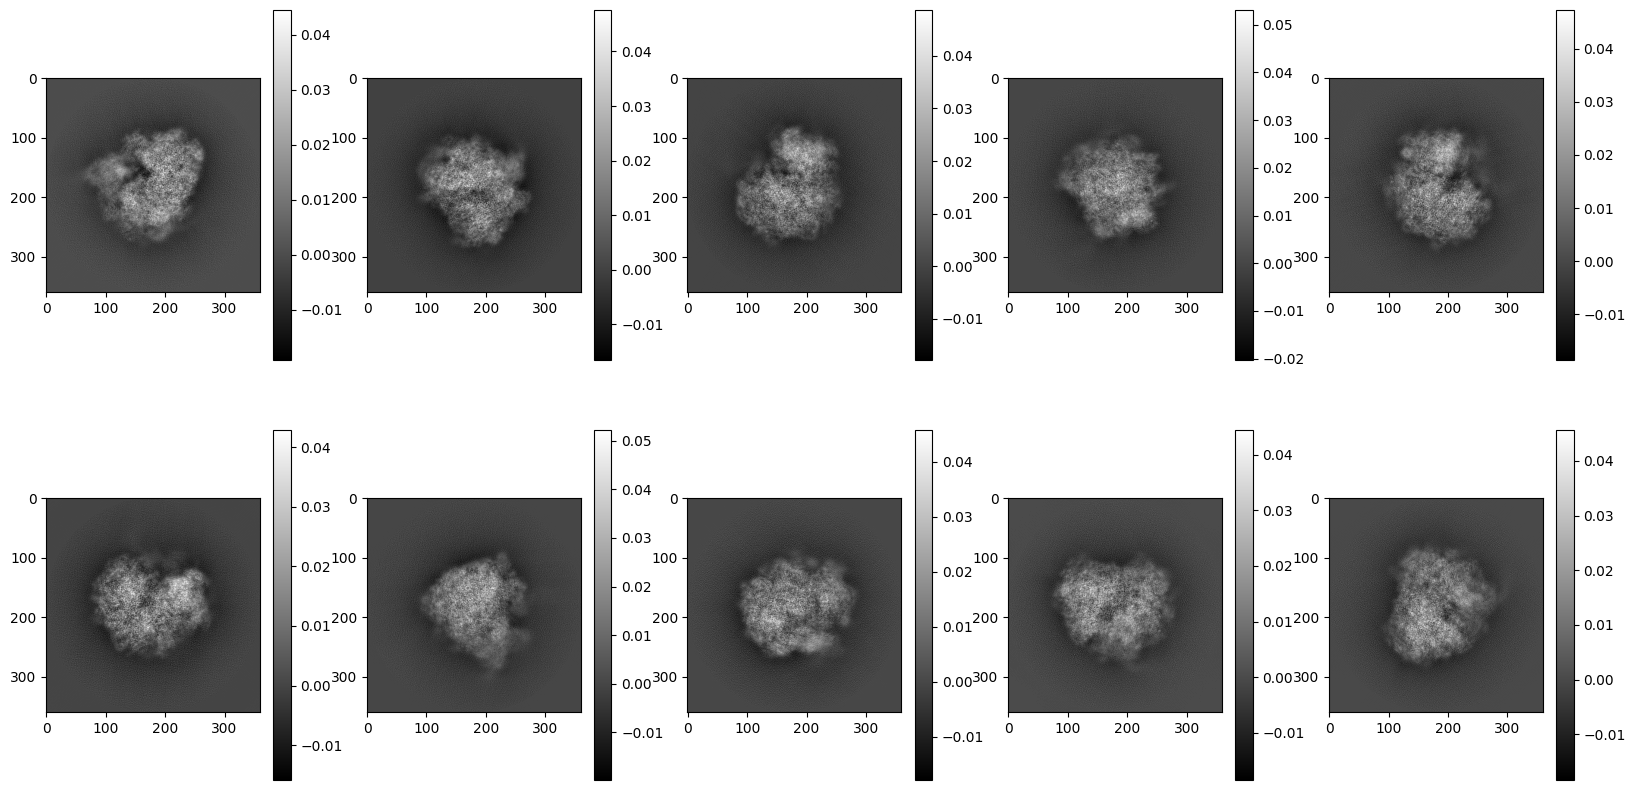

In [27]:
# estimate the mean volume by supplying the class averages and rotation estimates for back projection.

from aspire.reconstruction import MeanEstimator

# Setup an estimator to perform the back projection.
estimator = MeanEstimator(oriented_src)

# Perform the estimation and save the volume.
estimated_volume = estimator.estimate()


# Comparison of Estimated Volume with Source Volume
# -------------------------------------------------
# To get a visual confirmation that our results are fine, we rotate
# the estimated volume by the estimated rotations and project along
# the z-axis.  These estimated projections should align with the
# original projection images.

# Get the first 10 projections from the estimated volume using the
# estimated orientations.  Recall that ``project`` returns an
# ``Image`` instance, which we can peek at with ``show``.
projections_est = estimated_volume.project(est_rotations[0:10])


print("-----Estimated Volume Projections______")
projections_est.show()

print("-----simulated source Projections______")
src.projections[0:10].show()

In [28]:
# Save reconstructed volume as MRC
estimated_volume.save("/kaggle/working/reconstructed_80s_ribosome.mrc", overwrite=True)
